In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import random
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, MaxPooling1D, BatchNormalization, GlobalMaxPooling1D, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam
from keras.optimizers.legacy import SGD
from keras.layers import LeakyReLU, ReLU, Activation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Disable warnings
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# Check TensorFlow version
print(tf.__version__)

# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.15.0
Num GPUs Available:  1


In [2]:
# Load data from JSON file
def load_data(filepath):
    return pd.read_csv(filepath)

# Preprocess data
def preprocess_data(df):
    #df['dialect'] = df['dialect'].replace('language', 'general')
    #df['input'] = df['input'].apply(lambda x: x.strip())
    return df

def view_data_balance(df, label_col):
    # Count the number of samples in each class
    class_counts = df[label_col].value_counts()
    # Create a bar plot
    plt.figure(figsize=(20, 12))
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.xlabel(label_col)
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.show()
    return class_counts

#return the number of unique classes
def get_class_count(df):
    class_count = df['language'].nunique()
    return class_count
    
# Create a balanced dataset
def balance_data(df, label_col, n_samples):
    samples = [df[df[label_col] == label][:n_samples] for label in df[label_col].unique()]
    return pd.concat(samples)

# create a function to shuffle the dataframe
def shuffle_dataframe(df):
    return df.sample(frac=1).reset_index(drop=True)

# vocabulary size
def calculate_vocabulary_size(df, column_name):
    # Tokenize the text into words
    words = df[column_name].str.split().explode().unique()
    # Count the number of unique words
    vocabulary_size = len(words)
    return vocabulary_size

#max_len calculator
def calculate_max_length(df, column_name):
    # Calculate the maximum length of any text entry in the specified column
    max_len = df[column_name].str.split().apply(len).max()
    return max_len

# Tokenization and padding
def tokenize_and_pad(texts, max_len, num_words):
    tokenizer = Tokenizer(num_words=num_words, oov_token="<UNK>")
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    return tokenizer, padded_sequences

# Build the model
def create_model(input_shape, num_classes, vocabulary_size, lr):
    model = Sequential([
        Embedding(input_dim=vocabulary_size+1, output_dim=192, input_length=input_shape),
       
        Conv1D(190, 3, padding='same', kernel_regularizer=l2(0.1)),
        Activation('relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.5),
        
        Conv1D(64, 5, padding='same', kernel_regularizer=l2(0.1)),
        Activation('relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.5),

        Flatten(),

        Dense(64, kernel_regularizer=l2(0.01)),
        Activation('relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Train the model
def train_model(model, X_train, y_train, X_validate, y_validate, epochs, batch_size):
    lr_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
    early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_validate, y_validate), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping, lr_schedule])
    return history

# Evaluate the model
def evaluate_model(model, X_test, y_test, label_names):
    predictions = model.predict(X_test)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_test, axis=1)
    print(classification_report(true_classes, predicted_classes, target_names=label_names))
    confusion_mtx = confusion_matrix(true_classes, predicted_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

    # set the entropy pool to 42 deep
def fix_random_seed(seed_value=42):
    np.random.seed(seed_value)  # Set the seed for NumPy functions
    random.seed(seed_value)     # Set the seed for Python's random module
    tf.random.set_seed(seed_value)  # Set the seed for TensorFlow

# Usage:
fix_random_seed(42)

number of unique classes:  16


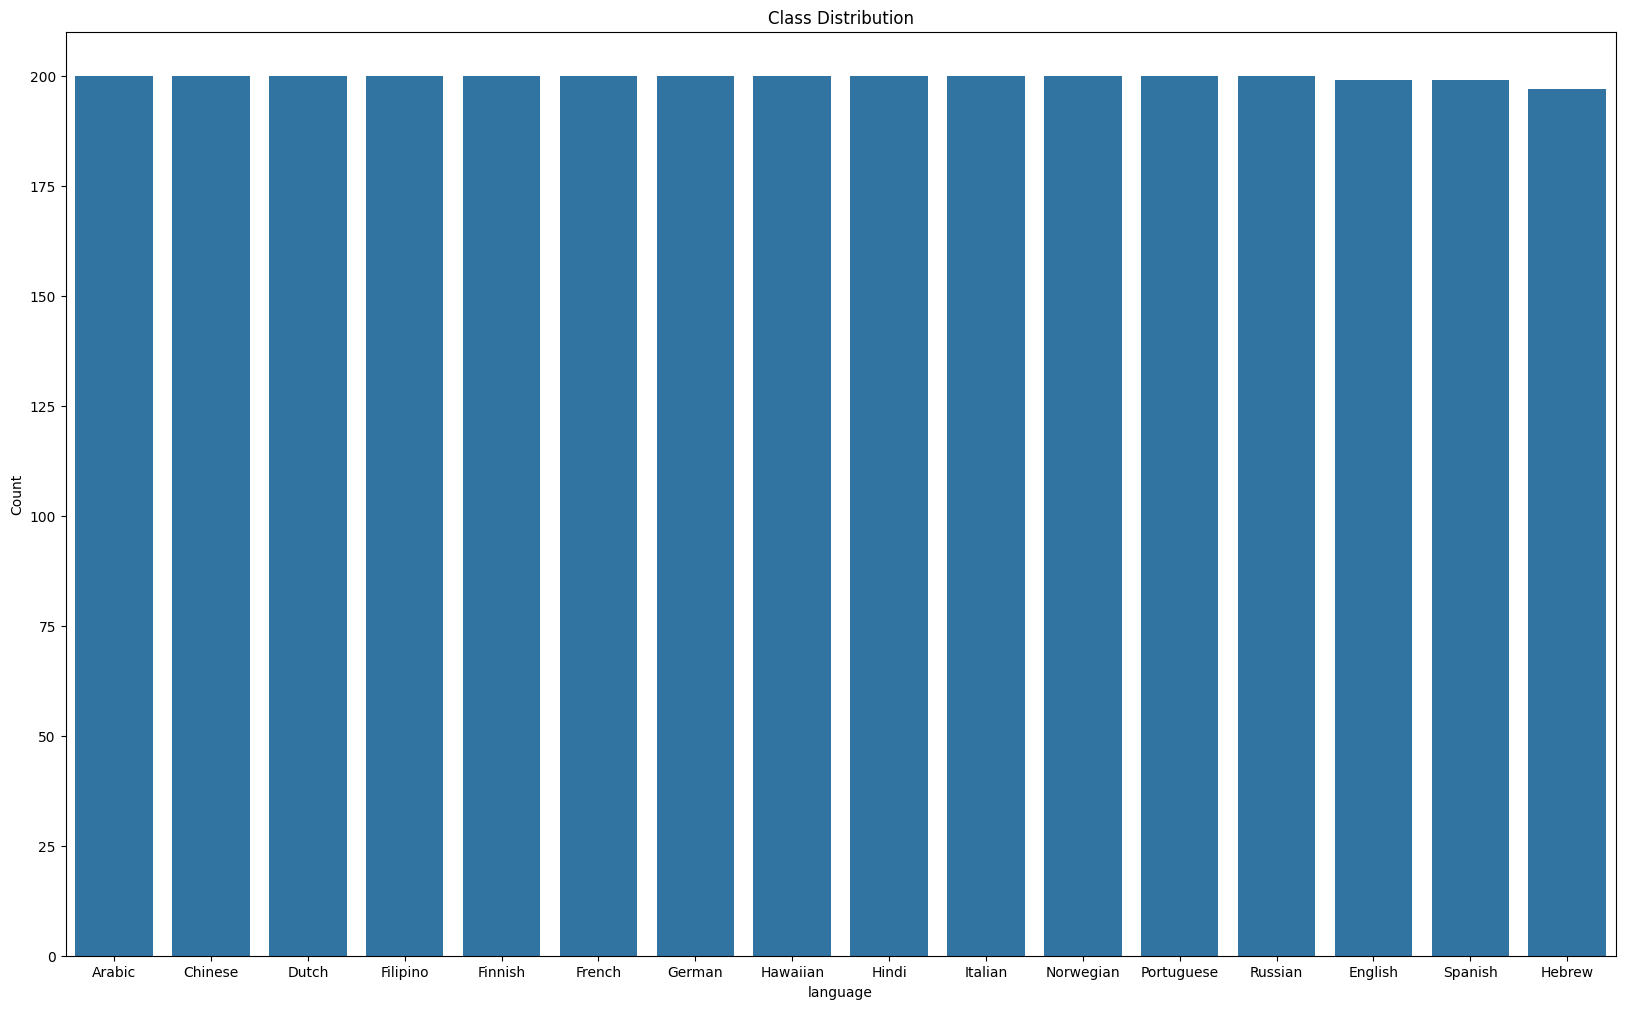

Arabic        200
Chinese       200
Dutch         200
Filipino      200
Finnish       200
French        200
German        200
Hawaiian      200
Hindi         200
Italian       200
Norwegian     200
Portuguese    200
Russian       200
English       199
Spanish       199
Hebrew        197
Name: language, dtype: int64


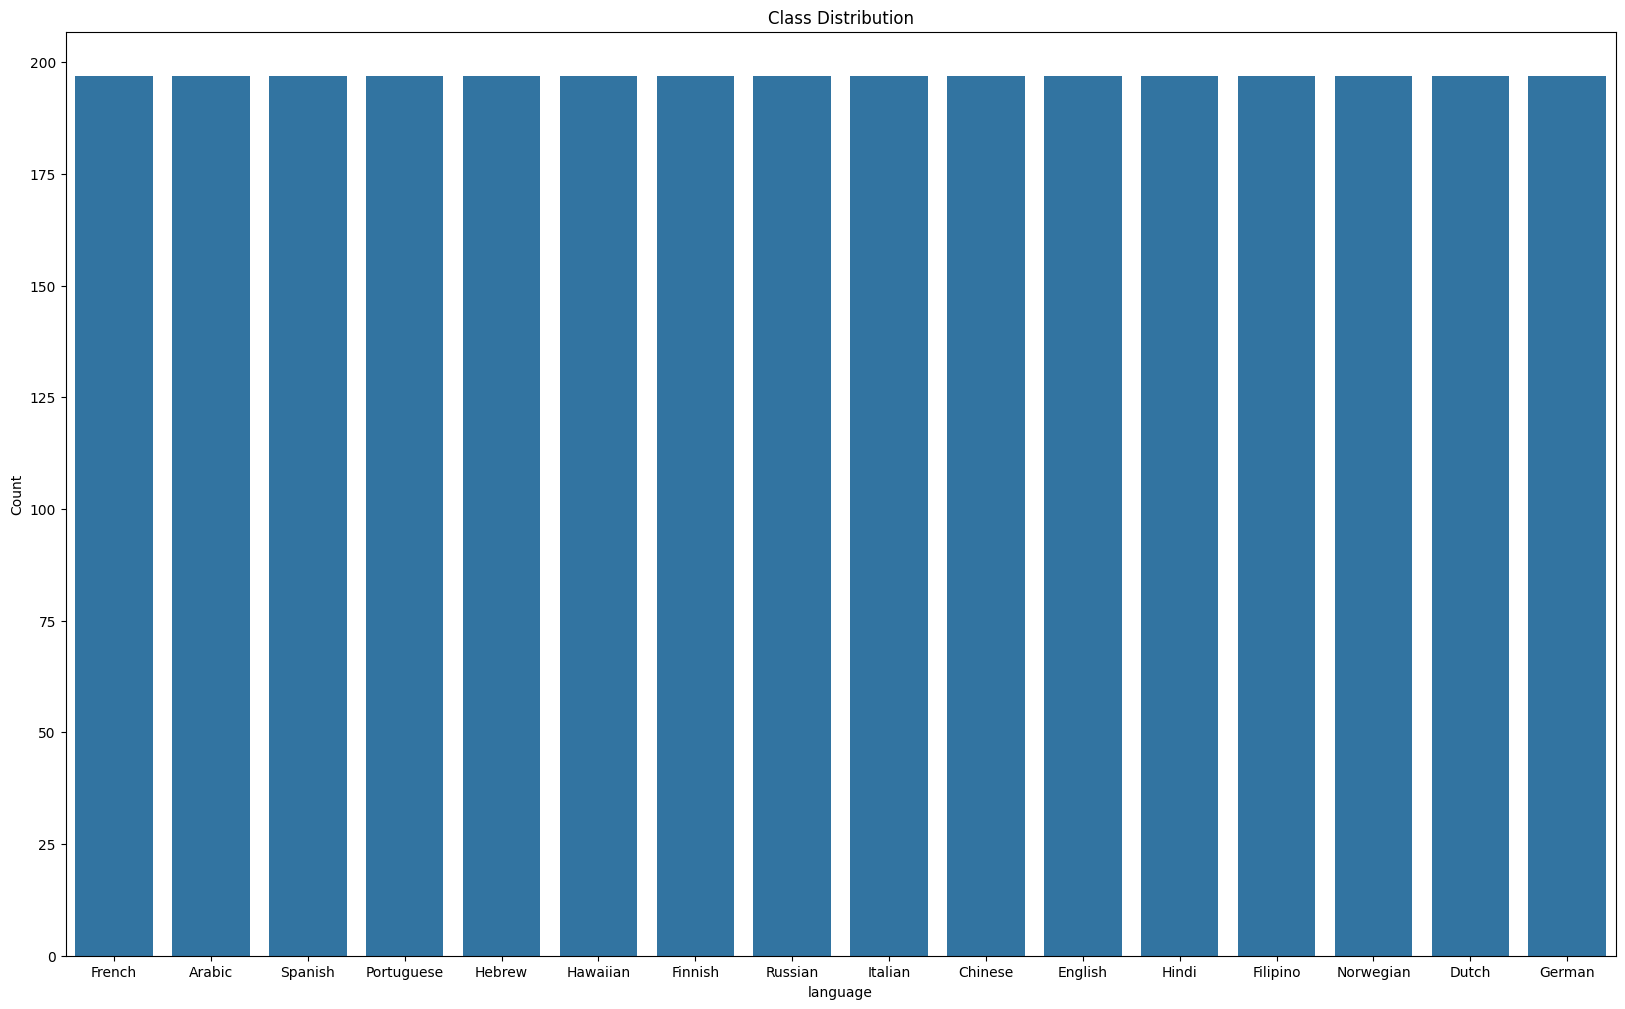

French        197
Arabic        197
Spanish       197
Portuguese    197
Hebrew        197
Hawaiian      197
Finnish       197
Russian       197
Italian       197
Chinese       197
English       197
Hindi         197
Filipino      197
Norwegian     197
Dutch         197
German        197
Name: language, dtype: int64
Vocabulary size: 7188
Maximum length: 41


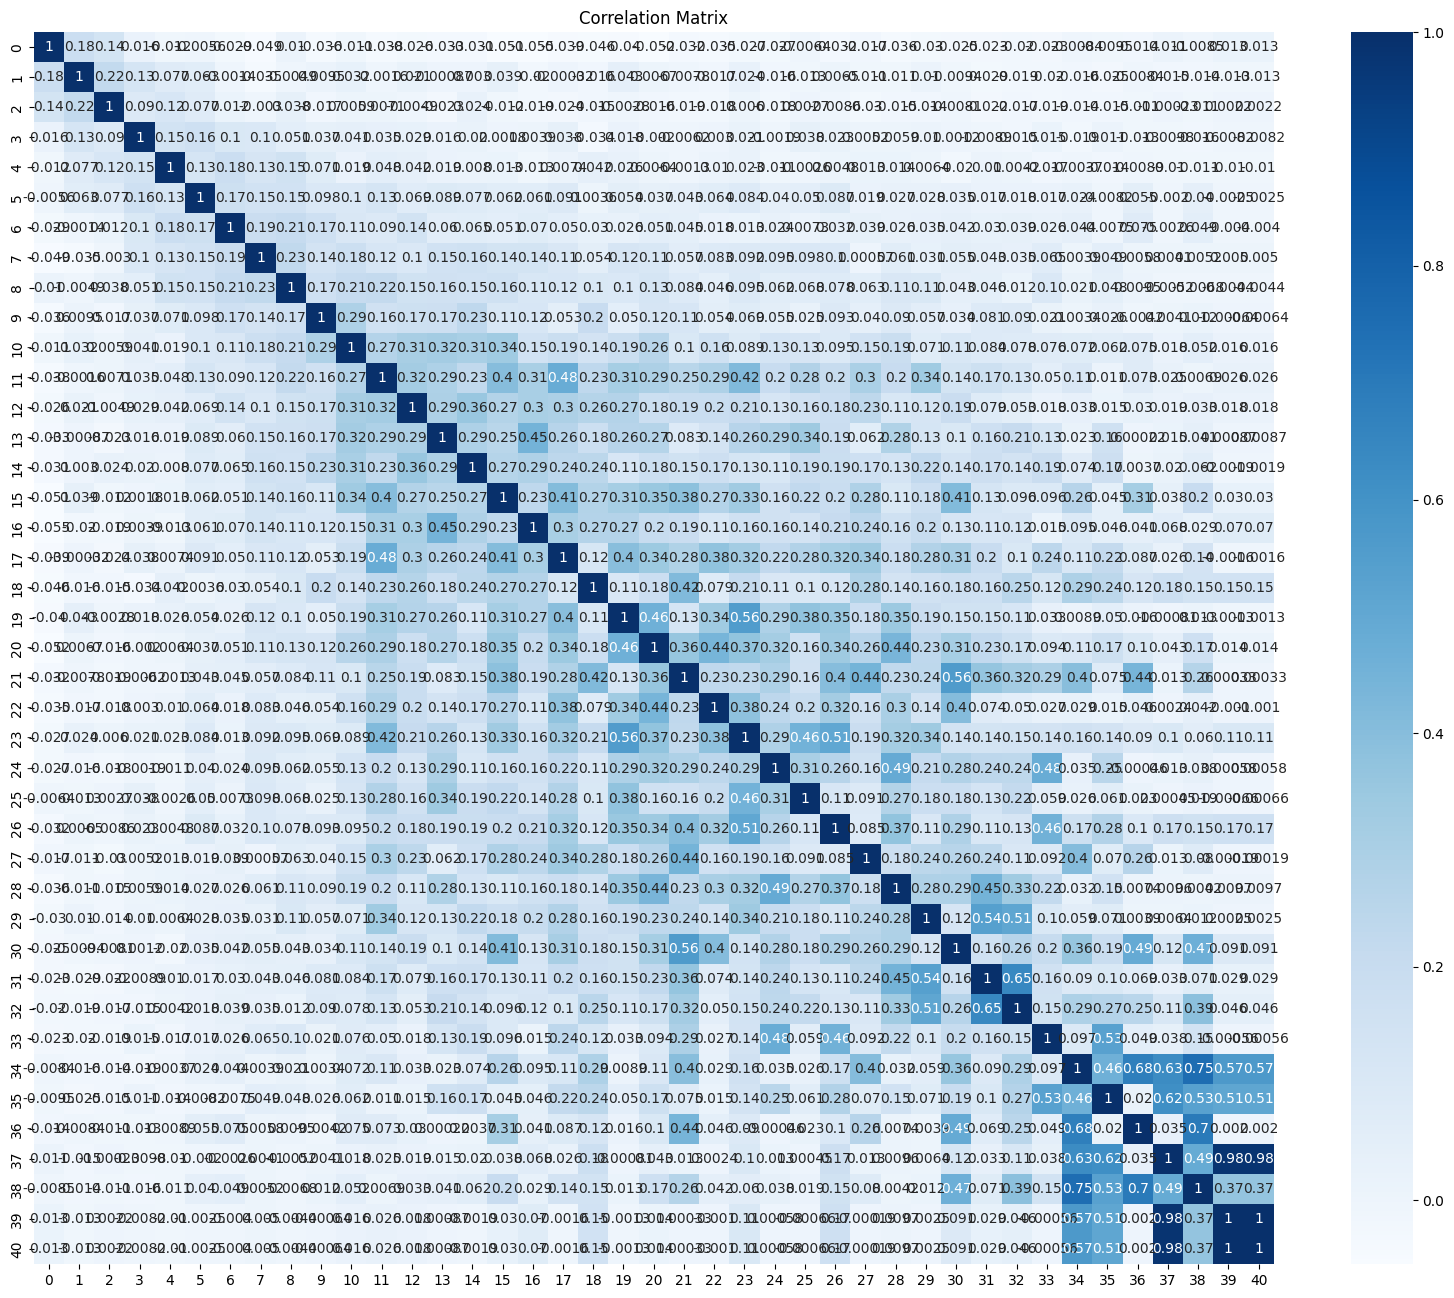

2024-05-28 22:45:55.716620: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-05-28 22:45:55.716645: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-05-28 22:45:55.716654: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-05-28 22:45:55.716756: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-28 22:45:55.716773: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 41, 192)           1380288   
                                                                 
 conv1d (Conv1D)             (None, 41, 190)           109630    
                                                                 
 activation (Activation)     (None, 41, 190)           0         
                                                                 
 batch_normalization (Batch  (None, 41, 190)           760       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 20, 190)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 20, 190)           0

2024-05-28 22:45:56.960525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-05-28 22:45:57.044181: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.


60/60 [==============================] - 5s 60ms/step - loss: 23.6416 - accuracy: 0.1788 - val_loss: 15.7856 - val_accuracy: 0.0602 - lr: 7.0000e-04
Epoch 2/100
60/60 [==============================] - 3s 48ms/step - loss: 12.8758 - accuracy: 0.3275 - val_loss: 11.3893 - val_accuracy: 0.0602 - lr: 7.0000e-04
Epoch 3/100
60/60 [==============================] - 3s 46ms/step - loss: 8.3796 - accuracy: 0.5307 - val_loss: 8.5561 - val_accuracy: 0.0602 - lr: 7.0000e-04
Epoch 4/100
60/60 [==============================] - 3s 47ms/step - loss: 5.4423 - accuracy: 0.7492 - val_loss: 6.9618 - val_accuracy: 0.0602 - lr: 7.0000e-04
Epoch 5/100
60/60 [==============================] - 3s 47ms/step - loss: 4.6448 - accuracy: 0.7497 - val_loss: 6.9535 - val_accuracy: 0.0602 - lr: 7.0000e-04
Epoch 6/100
60/60 [==============================] - 3s 48ms/step - loss: 3.4189 - accuracy: 0.9132 - val_loss: 6.2506 - val_accuracy: 0.0602 - lr: 7.0000e-04
Epoch 7/100
60/60 [==============================] - 3

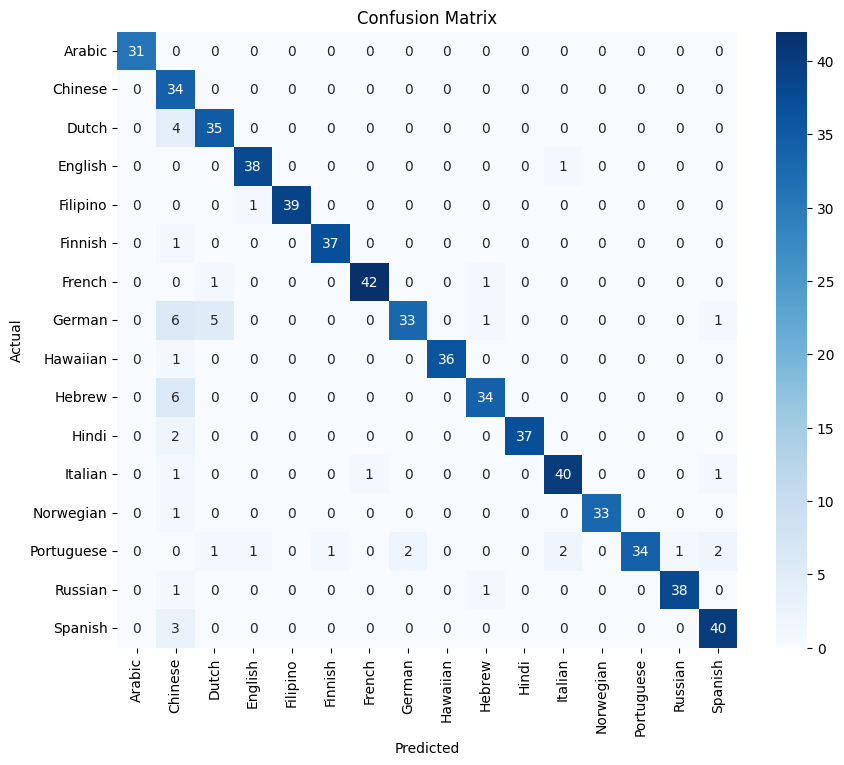

In [3]:
# Based on hypertuning results using the best hyperparameters
# Best parameters: {'batch_size': 32, 'l2_reg': 0.1, 'activation_fn': 'relu', 'dropout_rate': 0.3}

# Main execution block
if __name__ == "__main__":
    epochs = 100
    batch_size = 32
    lr = 0.0007
    # Load and preprocess data
    df = load_data('data/languages.csv')
    df = preprocess_data(df)

    #print number of unique classes
    n_classes = get_class_count(df)
    print('number of unique classes: ', n_classes)

    # view data balance
    class_counts = view_data_balance(df, 'language')
    print(class_counts)
    
    # # based on the data balance, create a balanced dataset of the same size as the smallest class = 13187
    df = balance_data(df, 'language', 197)
    
    # # shuffle the dataframe
    df = shuffle_dataframe(df)
    df = shuffle_dataframe(df)
    
    # # view data balance
    class_counts = view_data_balance(df, 'language')
    print(class_counts)

    # # calculate the vocabulary size and max_len
    vocabulary_size = calculate_vocabulary_size(df, 'input')
    print(f'Vocabulary size: {vocabulary_size}')

    max_len = calculate_max_length(df, 'input')
    print(f'Maximum length: {max_len}')

    # # Tokenization and encoding labels
    tokenizer, X_padded = tokenize_and_pad(df['input'],max_len,vocabulary_size)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(df['language'])
    y_categorical = to_categorical(y_encoded)

    # # create a correlaton matrix for y_encoded
    corr = pd.DataFrame(X_padded).corr()
    plt.figure(figsize=(20, 16))
    sns.heatmap(corr, annot=True, cmap='Blues')
    plt.title('Correlation Matrix')
    plt.show()

    # # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)
    X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

    # # Model creation and training
    model = create_model(X_train.shape[1], y_train.shape[1], vocabulary_size, lr)
    model.summary()
    history = train_model(model, X_train, y_train, X_validate, y_validate, epochs, batch_size)

    # # Model evaluation
    evaluate_model(model, X_test, y_test, label_encoder.classes_)

In [4]:
# # Hyperparameter Tuning

# # Modified create model function
# def create_model_pt(input_shape, num_classes, vocabulary_size, lr, l2_reg, activation_fn, dropout_rate):
#     model = Sequential([
#         Embedding(input_dim=vocabulary_size+1, output_dim=128, input_length=input_shape),
        
#         Conv1D(512, 5, padding='same', kernel_regularizer=l2(l2_reg)),
#         Activation(activation_fn),
#         BatchNormalization(),
#         MaxPooling1D(2),
#         Dropout(dropout_rate),

#         Conv1D(256, 5, padding='same', kernel_regularizer=l2(l2_reg)),
#         Activation(activation_fn),
#         BatchNormalization(),
#         MaxPooling1D(2),
#         Dropout(dropout_rate),
        
#         Conv1D(128, 5, padding='same', kernel_regularizer=l2(l2_reg)),
#         Activation(activation_fn),
#         BatchNormalization(),
#         MaxPooling1D(2),
#         Dropout(dropout_rate),
        
#         Conv1D(64, 5, padding='same', kernel_regularizer=l2(l2_reg)),
#         Activation(activation_fn),
#         BatchNormalization(),
#         MaxPooling1D(2),
#         Dropout(dropout_rate),
        
#         Conv1D(32, 5, padding='same', kernel_regularizer=l2(l2_reg)),
#         Activation(activation_fn),
#         BatchNormalization(),
#         MaxPooling1D(2),
#         Dropout(dropout_rate),

#         GlobalMaxPooling1D(),
        
#         Dense(64, kernel_regularizer=l2(l2_reg)),
#         Activation(activation_fn),
#         BatchNormalization(),
#         Dropout(dropout_rate),

#         Dense(num_classes, activation='softmax')
#     ])
#     model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# # Hyperparameter tuning
# batch_sizes = [32, 48, 64]
# l2_regs = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1]
# activation_fns = ['relu', 'leaky_relu']
# dropout_rates = [0.3, 0.5, 0.7]
# activation_fn = 'relu'
# dropout_rate = 0.3

# best_accuracy = 0
# best_params = {}
# poolsize =2

# for batch_size in batch_sizes:
#     for l2_reg in l2_regs:
#         #for activation_fn in activation_fns:
#             #for dropout_rate in dropout_rates:
#                     fix_random_seed(42)
#                     # Create and train model
#                     model = create_model_pt(input_shape=max_len, num_classes=20, vocabulary_size=vocabulary_size, lr=0.0005, l2_reg=l2_reg, activation_fn=activation_fn, dropout_rate=dropout_rate)
#                     history = train_model(model, X_train, y_train, X_validate, y_validate, epochs=10, batch_size=batch_size)
#                     # Evaluate the model
#                     accuracy = history.history['val_accuracy'][-1]
#                     if accuracy > best_accuracy:
#                         best_accuracy = accuracy
#                         best_params = {
#                             'batch_size': batch_size,
#                             'l2_reg': l2_reg,
#                             'activation_fn': activation_fn,
#                             'dropout_rate': dropout_rate
#                         }
#                     print(f"Tested parameters: batch_size={batch_size}, l2_reg={l2_reg}, activation_fn={activation_fn}, dropout_rate={dropout_rate}, pool_size={2} => Accuracy: {accuracy}")

# print(f"Best parameters: {best_params} with accuracy {best_accuracy}")


In [5]:
model.save('model_weights.h5')

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('label_encoder.pickle', 'wb') as handle:
    pickle.dump(label_encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)
    